In [1]:
import pickle5 as pickle
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import numpy as np

In [2]:
#lstm generator architecture
from torch import nn
from torch.nn.utils import spectral_norm


class AddDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)


class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)

#Banushev
# def create_critic_architecture():
#     return nn.Sequential(nn.Conv1d(1, 32, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.Conv1d(32, 64, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(64),
#     nn.Conv1d(64, 128, kernel_size=1, stride=2),
#     nn.LeakyReLU(0.01),
#     nn.BatchNorm1d(128),
#     nn.Linear (128, 220, bias=False), nn.BatchNorm1d(220), nn.LeakyReLU(0.01),
#     nn.Linear (220, 220, bias=False), nn.ReLU(),
#     nn.Linear(220, 1))
                         

def create_critic_architecture():
    return nn.Sequential(AddDimension(),
                         spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         
                         
                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Flatten(),

                         nn.Linear(32, 50),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(50, 15),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(15, 1)
                         )


class Generator(nn.Module):
    def __init__(self, num_embed=20, num_hidden=500, num_layers=1, sequence_length=17, output_size = 1, bidirectional=False):
        
        nn.Module.__init__(self)
        
        self.num_hidden = num_hidden
        
        self.rnn = nn.LSTM(num_embed, num_hidden, num_layers, bidirectional=bidirectional)
        self.decoder = nn.Linear(num_hidden, output_size)
    
    def forward(self, inputs):
        output, hidden = self.rnn(inputs)
        decoded = self.decoder(output)
        return decoded
    


class Critic(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.main = create_critic_architecture()

    def forward(self, inputs):
        return self.main(inputs)

In [65]:
ticker_data_file = 'data/ticker_data.xlsx'
ticker_data = pd.read_excel(ticker_data_file)
tickers = ticker_data['Symbol'].to_list()
tickers_str = ''
for ticker in tickers:
    #delisted
    if (ticker != 'BRK.B'):
        tickers_str = tickers_str + ticker + ' '
tickers_str = tickers_str[:len(tickers_str)-1]
tickers.remove('BRK.B')

In [66]:
price_data = yf.download( 
        tickers = tickers_str,
        start="2018-01-01", end="2020-12-31",
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None)

[*********************100%***********************]  49 of 49 completed


In [67]:
price_df = pd.DataFrame({})
for tick in tickers:
    df = price_data[tick]['Open']
    price_df[tick] = df

In [68]:
#inspect na, remove paypal
price_df.isnull().sum()
price_df = price_df.drop (['PYPL'],axis=1)

In [69]:
#technical indicators
factor_list = ['macd', 'mom', 'rsi', 'slope', 'stoch', 'sma', 'vwap', 'mad', 'stdev', 'variance', 'bbands', 'adx', 'entropy', 'stochrsi']

In [70]:
#technical indicators
factor_data = {}
for factor_name in factor_list:
    try:
        factor_df = pd.DataFrame({})
        shift = True
        for tick in price_df.columns:
            ta_df = price_data[tick]
            factor_df[tick] = getattr(ta_df.copy().ta, factor_name)()
        factor_df = factor_df.shift(int(shift))
        factor_data[factor_name] = factor_df
    except:
        continue

In [71]:
#remaining factors
print (factor_data.keys())

dict_keys(['mom', 'rsi', 'slope', 'sma', 'vwap', 'mad', 'stdev', 'variance', 'entropy'])


In [72]:
#fourier transform
fourier_df = pd.DataFrame({}, index = price_data.index)
for tick in price_df.columns:
    df = price_data[tick]['Close']
    
    fourier_df[tick] = np.fft.fft(np.asarray(df.tolist()))
# factor_df = factor_df.stack()
# factor_df.index = factor_df.index.set_names(['date', 'asset'])

In [73]:
for tick in price_df.columns:
    fft_list = fourier_df[tick]
    num = 3
    fft_list_m10= np.copy(fft_list); 
    fft_list_m10[num:-num]=0
    ifft = np.fft.ifft(fft_list_m10)
    fourier_df[tick] = ifft

In [74]:
#create data to use 
data_final = pd.DataFrame(index = price_df.index)
data_final['AAPL'] = price_df['AAPL']
for i, ticker in enumerate(price_df.columns):
    if (i < 10):
        data_final[ticker] = price_df[ticker]
        
data_final['Fourier'] = fourier_df['AAPL']
for factor in factor_data.keys():
    data_final[factor] = factor_data[factor]['AAPL']
data_final = data_final.dropna(how = 'any', axis = 0)




In [75]:
#turn data into their format
data_final_list = []
example_size = 18
for i in range (data_final.shape[0]-example_size):
    example = data_final.iloc[i:example_size+i].to_dict('series')
    for key in example.keys():
        example[key] = example[key].astype('float').to_list()
    data_final_list.append(example)

/Users/Nick/anaconda3/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1097: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [89]:
data_final_list[0]

{'AAPL': [39.325099048335794,
  40.9531965015118,
  41.573079981225256,
  41.49830851445851,
  41.68644532390271,
  41.4380110165246,
  41.88905706729254,
  42.53546369657796,
  43.19876842403252,
  43.23734626277392,
  43.0636897720483,
  41.679207677414226,
  42.26049590117321,
  42.91174392639277,
  42.19536831365334,
  42.325612623920605,
  42.92379500716322,
  43.485779515663076],
 'MSFT': [85.04008882225001,
  87.63423047989212,
  88.82562019868055,
  87.89365183016734,
  89.33483566259007,
  88.44129697236535,
  89.93053214058953,
  90.69915983396622,
  91.98663088826396,
  91.1219238893577,
  90.30524528246774,
  87.98972786032624,
  88.71993304276566,
  90.64151561229666,
  89.50778156022346,
  90.57425827990359,
  91.55427658543525,
  92.71683793319008],
 'AMZN': [1406.25,
  1466.8900146484375,
  1457.3699951171875,
  1446.489990234375,
  1485.0,
  1495.3599853515625,
  1495.3399658203125,
  1509.199951171875,
  1524.5,
  1519.510009765625,
  1513.5999755859375,
  1469.099975

In [77]:
train_data_proportion = int(.8*len(data_final_list))
train_data = data_final_list[:train_data_proportion]
test_data = data_final_list[train_data_proportion:]

In [78]:
import argparse
import os


import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from math import pi

In [91]:
from sklearn.metrics import mean_absolute_error
class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=50, use_cuda=False, checkpoint_frequency=200):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.checkpoint_frequency = checkpoint_frequency

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, data):
    
        #My code
        #create generator data
        data_size = len(data['AAPL']) - 1
        generator_data = []
        for key in data.keys():
            generator_data.append([t.numpy() for t in data[key][:data_size]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        
       
        #create critic data
        critic_data = torch.from_numpy(np.array([t.numpy() for t in data['AAPL'][data_size:]]).astype('float64'))
        critic_data = Variable(critic_data)
        critic_data = critic_data.permute (1, 0)
        
        
        generated_data = self.g(generator_data.float()) 
        # Get gradient penalty
#         print (generated_data.shape)
        generated_data = torch.unsqueeze(torch.squeeze(generated_data, 2).permute(1,0)[:,16], 1)

        # Pass data through the Critic
#         print (critic_data.shape)
#         print (generated_data.shape)
        
        c_real = self.c(critic_data.float())
        c_generated = self.c(generated_data.float())

#       
#         print ('here')
#         print (generated_data.shape)
#         print (critic_data.shape)

       

        gradient_penalty = self._gradient_penalty(critic_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.c_opt.zero_grad()
        d_loss = c_generated.mean() - c_real.mean() + gradient_penalty
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        
        #create generator data
        data_size = len(data['AAPL']) - 1
        generator_data = []
        for key in data.keys():
            generator_data.append([t.numpy() for t in data[key][:data_size]])
        generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
        generator_data = generator_data.permute(1, 2, 0)
        generator_result= self.g(generator_data.float())
        
        
        generator_result = torch.unsqueeze(torch.squeeze(generator_result, 2).permute(1,0)[:,16], 1)
        # Calculate loss and optimize
        d_generated = self.c(generator_result.float())
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):
        
#         print (real_data.shape)
#         print (generated_data.shape)
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        interpolated = Variable(interpolated, requires_grad=True)
#         print (interpolated.shape)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated.float())

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch, writer):
        for i, data in enumerate(data_loader):
            
            #my code 
            data_size = 100
            #print (len(data['AAPL']))
            
            
            self.num_steps += 1
            self._critic_train_iteration(data)
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

            if i % self.print_every == 0:
                global_step = i + epoch * len(data_loader.dataset)
                writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
                writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
                writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)

                if self.num_steps > self.critic_iterations:
                    writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, data_list, epochs, plot_training_samples=True, checkpoint=None, writer=None):
        
        eval_data = []
        for data in test_data:
            generator_data = []
            for key in data.keys():
                generator_data.append(data[key])
            generator_data = torch.from_numpy(np.array(generator_data).astype('float64'))
            generator_data = torch.unsqueeze (generator_data, 0)
            data_cur = generator_data.permute(2, 0, 1)
            eval_data.append(data_cur)
        
        if checkpoint:
            path = os.path.join('checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])
       
#         # Define noise_shape
#         noise_shape = (1, self.NOISE_LENGTH)
        
#         if plot_training_samples:
#             # Fix latents to see how series generation improves during training
#             fixed_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 fixed_latents = fixed_latents.cuda()

        #my code
        self.g = self.g.float()
        self.c = self.c.float()
        
        returns_generated = []
        returns_true = []
        MAE_list = []
        
        for epoch in tqdm(range(epochs)):

#             # Sample a different region of the latent distribution to check for mode collapse
#             dynamic_latents = Variable(self.sample_latent(noise_shape))
#             if self.use_cuda:
#                 dynamic_latents = dynamic_latents.cuda()

            self._train_epoch(data_loader, epoch + 1, writer)

#             # Save checkpoint
#             if epoch % self.checkpoint_frequency == 0:
#                 torch.save({
#                     'epoch': epoch,
#                     'd_state_dict': self.c.state_dict(),
#                     'g_state_dict': self.g.state_dict(),
#                     'd_opt_state_dict': self.c_opt.state_dict(),
#                     'g_opt_state_dict': self.g_opt.state_dict(),
#                 }, 'checkpoints/epoch_{}.pkl'.format(epoch))

            if plot_training_samples and (epoch % self.print_every == 0):
                self.g.eval()
            
                # Generate eval result (last sample period)
                returns_generated = []
                returns_true = []
                for data in eval_data:
                    train = data[:17, :, :]
                    true_val = data[17, :, 0]
                    generator_result= self.g(train.float())
                    generator_result = torch.squeeze(generator_result, 2).permute(1,0)[:,16]
                    returns_generated.append(generator_result.detach().numpy()[0])
                    returns_true.append(true_val.numpy()[0])
                MAE = mean_absolute_error(returns_true, returns_generated)
                MAE_list.append(MAE)
                    
                print ("MAE")
                print (MAE)
                print ()
                
                plt.figure()
                plt.plot(returns_generated, label = 'generated')
                plt.plot (returns_true, label = 'true')
                plt.show()
                #plt.savefig('training_samples/fixed_latents/series_epoch_{}.png'.format(epoch))
                plt.close()

#                 plt.figure()
#                 plt.plot(fake_data_dynamic_latents.numpy()[0].T)
#                 #plt.savefig('training_samples/dynamic_latents/series_epoch_{}.png'.format(epoch))
#                 plt.show()
#                 plt.close()
                self.g.train()
        return returns_generated, returns_true
#     def sample_generator(self, latent_shape):
#         latent_samples = Variable(self.sample_latent(latent_shape))
#         if self.use_cuda:
#             latent_samples = latent_samples.cuda()

#         return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


def run_GAN():


    batch_size = 16
    epochs = 1400
    log_name = 'tensorboard_log_name'
    checkpoint = None
    

    # Instantiate Generator and Critic + initialize weights
    g = Generator()

    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
    d = Critic()

    d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)
    
    #Create Dataloader
    dataset = train_data
    dataloader = DataLoader(dataset, batch_size=batch_size)


    # Instantiate Trainer
    trainer = Trainer(g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available())
    # Train model
    print('Training is about to start...')
    # Instantiate Tensorboard writer
    tb_logdir = os.path.join('..', 'tensorboard', log_name)
    writer = SummaryWriter(tb_logdir)

    returns = trainer.train(dataloader, data_final_list, epochs=epochs, plot_training_samples=True, checkpoint=checkpoint, writer=writer)
    return returns









  0%|          | 0/1400 [00:00<?, ?it/s]

Training is about to start...
MAE
110.58275885030253



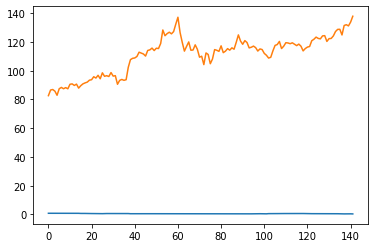









  0%|          | 1/1400 [00:07<2:48:24,  7.22s/it]







  0%|          | 2/1400 [00:13<2:42:28,  6.97s/it]







  0%|          | 3/1400 [00:20<2:39:29,  6.85s/it]







  0%|          | 4/1400 [00:26<2:36:19,  6.72s/it]







  0%|          | 5/1400 [00:33<2:34:51,  6.66s/it]







  0%|          | 6/1400 [00:39<2:32:11,  6.55s/it]







  0%|          | 7/1400 [00:46<2:32:35,  6.57s/it]







  1%|          | 8/1400 [00:52<2:33:04,  6.60s/it]







  1%|          | 9/1400 [00:59<2:32:58,  6.60s/it]







  1%|          | 10/1400 [01:05<2:33:25,  6.62s/it]







  1%|          | 11/1400 [01:12<2:31:52,  6.56s/it]







  1%|          | 12/1400 [01:18<2:29:25,  6.46s/it]







  1%|          | 13/1400 [01:24<2:27:51,  6.40s/it]







  1%|          | 14/1400 [01:31<2:27:27,  6.38s/it]







  1%|          | 15/1400 [01:37<2:27:51,  6.41s/it]







  1%|          | 16/1400 [01:44<2:27:26,  6.39s/it]







  1%|          | 17/1400 [01:50<2:28:03,  6.42s/it]







MAE
105.37420119418898



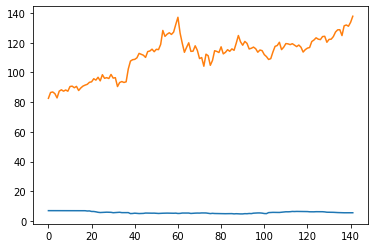









  4%|▎         | 51/1400 [05:33<2:31:58,  6.76s/it]







  4%|▎         | 52/1400 [05:40<2:30:58,  6.72s/it]







  4%|▍         | 53/1400 [05:47<2:29:56,  6.68s/it]







  4%|▍         | 54/1400 [05:53<2:27:51,  6.59s/it]







  4%|▍         | 55/1400 [06:00<2:27:06,  6.56s/it]







  4%|▍         | 56/1400 [06:06<2:24:45,  6.46s/it]







  4%|▍         | 57/1400 [06:12<2:25:08,  6.48s/it]







  4%|▍         | 58/1400 [06:19<2:25:04,  6.49s/it]







  4%|▍         | 59/1400 [06:25<2:24:33,  6.47s/it]







  4%|▍         | 60/1400 [06:32<2:24:27,  6.47s/it]







  4%|▍         | 61/1400 [06:38<2:23:12,  6.42s/it]







  4%|▍         | 62/1400 [06:45<2:23:49,  6.45s/it]







  4%|▍         | 63/1400 [06:51<2:23:53,  6.46s/it]







  5%|▍         | 64/1400 [06:57<2:23:18,  6.44s/it]







  5%|▍         | 65/1400 [07:04<2:23:08,  6.43s/it]







  5%|▍         | 66/1400 [07:10<2:22:07,  6.39s/it]







  5%|▍         | 67/1400 [07:17<2:22:24,  6.41s/

MAE
102.49244115438933



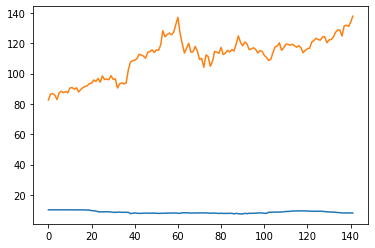









  7%|▋         | 101/1400 [10:56<2:26:05,  6.75s/it]







  7%|▋         | 102/1400 [11:03<2:26:28,  6.77s/it]







  7%|▋         | 103/1400 [11:10<2:24:58,  6.71s/it]







  7%|▋         | 104/1400 [11:16<2:23:42,  6.65s/it]







  8%|▊         | 105/1400 [11:23<2:23:17,  6.64s/it]







  8%|▊         | 106/1400 [11:29<2:21:59,  6.58s/it]







  8%|▊         | 107/1400 [11:36<2:21:31,  6.57s/it]







  8%|▊         | 108/1400 [11:42<2:21:38,  6.58s/it]







  8%|▊         | 109/1400 [11:49<2:21:31,  6.58s/it]







  8%|▊         | 110/1400 [11:56<2:21:51,  6.60s/it]







  8%|▊         | 111/1400 [12:02<2:20:51,  6.56s/it]







  8%|▊         | 112/1400 [12:08<2:19:05,  6.48s/it]







  8%|▊         | 113/1400 [12:15<2:18:06,  6.44s/it]







  8%|▊         | 114/1400 [12:21<2:17:53,  6.43s/it]







  8%|▊         | 115/1400 [12:28<2:18:20,  6.46s/it]







  8%|▊         | 116/1400 [12:34<2:17:49,  6.44s/it]







  8%|▊         | 117/1400 [12:41

MAE
100.02804558094792



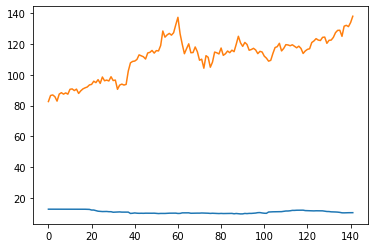









 11%|█         | 151/1400 [16:19<2:15:30,  6.51s/it]







 11%|█         | 152/1400 [16:25<2:13:03,  6.40s/it]







 11%|█         | 153/1400 [16:31<2:11:29,  6.33s/it]







 11%|█         | 154/1400 [16:37<2:10:18,  6.28s/it]







 11%|█         | 155/1400 [16:44<2:09:35,  6.25s/it]







 11%|█         | 156/1400 [16:50<2:07:12,  6.14s/it]







 11%|█         | 157/1400 [16:55<2:05:58,  6.08s/it]







 11%|█▏        | 158/1400 [17:02<2:05:46,  6.08s/it]







 11%|█▏        | 159/1400 [17:08<2:07:34,  6.17s/it]







 11%|█▏        | 160/1400 [17:15<2:11:00,  6.34s/it]







 12%|█▏        | 161/1400 [17:21<2:11:19,  6.36s/it]







 12%|█▏        | 162/1400 [17:28<2:11:43,  6.38s/it]







 12%|█▏        | 163/1400 [17:34<2:11:59,  6.40s/it]







 12%|█▏        | 164/1400 [17:40<2:12:33,  6.43s/it]







 12%|█▏        | 165/1400 [17:47<2:12:38,  6.44s/it]







 12%|█▏        | 166/1400 [17:53<2:10:48,  6.36s/it]







 12%|█▏        | 167/1400 [17:59

MAE
97.65110821843821



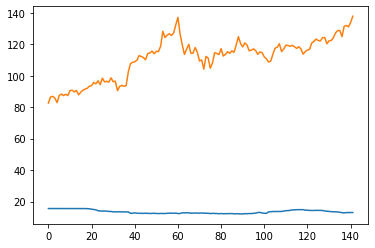









 14%|█▍        | 201/1400 [21:38<2:14:44,  6.74s/it]







 14%|█▍        | 202/1400 [21:44<2:13:12,  6.67s/it]







 14%|█▍        | 203/1400 [21:51<2:12:09,  6.62s/it]







 15%|█▍        | 204/1400 [21:57<2:09:24,  6.49s/it]







 15%|█▍        | 205/1400 [22:03<2:08:14,  6.44s/it]







 15%|█▍        | 206/1400 [22:10<2:06:57,  6.38s/it]







 15%|█▍        | 207/1400 [22:16<2:07:46,  6.43s/it]







 15%|█▍        | 208/1400 [22:23<2:07:53,  6.44s/it]







 15%|█▍        | 209/1400 [22:29<2:08:23,  6.47s/it]







 15%|█▌        | 210/1400 [22:36<2:08:52,  6.50s/it]







 15%|█▌        | 211/1400 [22:42<2:08:38,  6.49s/it]







 15%|█▌        | 212/1400 [22:49<2:08:35,  6.49s/it]







 15%|█▌        | 213/1400 [22:55<2:07:18,  6.44s/it]







 15%|█▌        | 214/1400 [23:02<2:07:23,  6.44s/it]







 15%|█▌        | 215/1400 [23:08<2:07:52,  6.48s/it]







 15%|█▌        | 216/1400 [23:14<2:06:55,  6.43s/it]







 16%|█▌        | 217/1400 [23:21

MAE
95.27448730790113



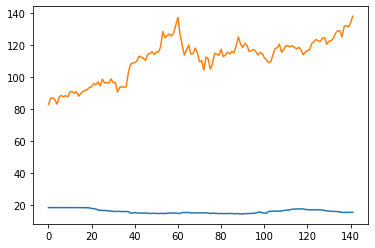









 18%|█▊        | 251/1400 [26:51<2:00:13,  6.28s/it]







 18%|█▊        | 252/1400 [26:57<1:57:48,  6.16s/it]







 18%|█▊        | 253/1400 [27:03<1:56:13,  6.08s/it]







 18%|█▊        | 254/1400 [27:09<1:55:53,  6.07s/it]







 18%|█▊        | 255/1400 [27:15<1:56:11,  6.09s/it]







 18%|█▊        | 256/1400 [27:21<1:55:31,  6.06s/it]







 18%|█▊        | 257/1400 [27:27<1:55:20,  6.06s/it]







 18%|█▊        | 258/1400 [27:33<1:55:21,  6.06s/it]







 18%|█▊        | 259/1400 [27:39<1:55:14,  6.06s/it]







 19%|█▊        | 260/1400 [27:45<1:55:33,  6.08s/it]







 19%|█▊        | 261/1400 [27:51<1:54:52,  6.05s/it]







 19%|█▊        | 262/1400 [27:57<1:54:16,  6.02s/it]







 19%|█▉        | 263/1400 [28:03<1:53:23,  5.98s/it]







 19%|█▉        | 264/1400 [28:09<1:52:41,  5.95s/it]







 19%|█▉        | 265/1400 [28:15<1:52:35,  5.95s/it]







 19%|█▉        | 266/1400 [28:21<1:52:18,  5.94s/it]







 19%|█▉        | 267/1400 [28:27

MAE
92.92679354895003



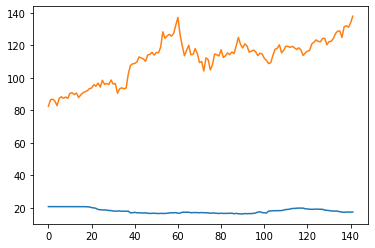









 22%|██▏       | 301/1400 [31:50<1:52:43,  6.15s/it]







 22%|██▏       | 302/1400 [31:56<1:51:49,  6.11s/it]







 22%|██▏       | 303/1400 [32:02<1:51:17,  6.09s/it]







 22%|██▏       | 304/1400 [32:08<1:50:46,  6.06s/it]







 22%|██▏       | 305/1400 [32:14<1:50:16,  6.04s/it]







 22%|██▏       | 306/1400 [32:20<1:48:36,  5.96s/it]







 22%|██▏       | 307/1400 [32:26<1:47:52,  5.92s/it]







 22%|██▏       | 308/1400 [32:32<1:47:21,  5.90s/it]







 22%|██▏       | 309/1400 [32:37<1:46:52,  5.88s/it]







 22%|██▏       | 310/1400 [32:43<1:46:57,  5.89s/it]







 22%|██▏       | 311/1400 [32:49<1:46:08,  5.85s/it]







 22%|██▏       | 312/1400 [32:55<1:46:00,  5.85s/it]







 22%|██▏       | 313/1400 [33:01<1:46:00,  5.85s/it]







 22%|██▏       | 314/1400 [33:07<1:45:54,  5.85s/it]







 22%|██▎       | 315/1400 [33:13<1:46:59,  5.92s/it]







 23%|██▎       | 316/1400 [33:19<1:47:14,  5.94s/it]







 23%|██▎       | 317/1400 [33:25

MAE
90.52081635353265



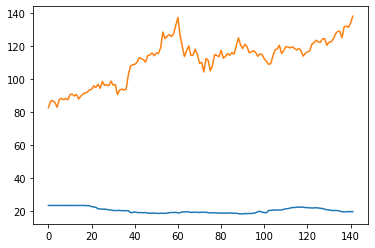









 25%|██▌       | 351/1400 [36:44<1:47:19,  6.14s/it]







 25%|██▌       | 352/1400 [36:50<1:46:12,  6.08s/it]







 25%|██▌       | 353/1400 [36:56<1:44:46,  6.00s/it]







 25%|██▌       | 354/1400 [37:02<1:43:31,  5.94s/it]







 25%|██▌       | 355/1400 [37:08<1:42:54,  5.91s/it]







 25%|██▌       | 356/1400 [37:13<1:41:43,  5.85s/it]







 26%|██▌       | 357/1400 [37:19<1:41:10,  5.82s/it]







 26%|██▌       | 358/1400 [37:25<1:40:54,  5.81s/it]







 26%|██▌       | 359/1400 [37:31<1:40:36,  5.80s/it]







 26%|██▌       | 360/1400 [37:37<1:40:41,  5.81s/it]







 26%|██▌       | 361/1400 [37:42<1:39:58,  5.77s/it]







 26%|██▌       | 362/1400 [37:48<1:39:49,  5.77s/it]







 26%|██▌       | 363/1400 [37:54<1:39:47,  5.77s/it]







 26%|██▌       | 364/1400 [38:00<1:39:41,  5.77s/it]







 26%|██▌       | 365/1400 [38:05<1:39:54,  5.79s/it]







 26%|██▌       | 366/1400 [38:11<1:39:17,  5.76s/it]







 26%|██▌       | 367/1400 [38:17

MAE
88.05255112902213



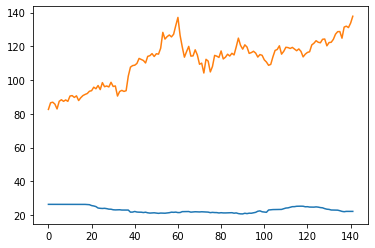









 29%|██▊       | 401/1400 [41:34<1:41:49,  6.12s/it]







 29%|██▊       | 402/1400 [41:40<1:39:52,  6.00s/it]







 29%|██▉       | 403/1400 [41:46<1:38:30,  5.93s/it]







 29%|██▉       | 404/1400 [41:52<1:37:31,  5.88s/it]







 29%|██▉       | 405/1400 [41:58<1:37:11,  5.86s/it]







 29%|██▉       | 406/1400 [42:03<1:36:06,  5.80s/it]







 29%|██▉       | 407/1400 [42:09<1:35:40,  5.78s/it]







 29%|██▉       | 408/1400 [42:15<1:35:34,  5.78s/it]







 29%|██▉       | 409/1400 [42:20<1:35:21,  5.77s/it]







 29%|██▉       | 410/1400 [42:26<1:35:26,  5.78s/it]







 29%|██▉       | 411/1400 [42:32<1:34:47,  5.75s/it]







 29%|██▉       | 412/1400 [42:38<1:34:33,  5.74s/it]







 30%|██▉       | 413/1400 [42:43<1:34:26,  5.74s/it]







 30%|██▉       | 414/1400 [42:49<1:34:21,  5.74s/it]







 30%|██▉       | 415/1400 [42:55<1:34:34,  5.76s/it]







 30%|██▉       | 416/1400 [43:01<1:33:57,  5.73s/it]







 30%|██▉       | 417/1400 [43:06

MAE
85.6512079311324



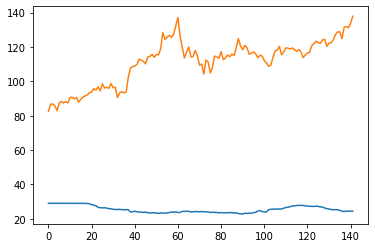









 32%|███▏      | 451/1400 [46:20<1:32:57,  5.88s/it]







 32%|███▏      | 452/1400 [46:26<1:31:44,  5.81s/it]







 32%|███▏      | 453/1400 [46:31<1:30:56,  5.76s/it]







 32%|███▏      | 454/1400 [46:37<1:30:23,  5.73s/it]







 32%|███▎      | 455/1400 [46:43<1:30:14,  5.73s/it]







 33%|███▎      | 456/1400 [46:48<1:28:47,  5.64s/it]







 33%|███▎      | 457/1400 [46:54<1:27:58,  5.60s/it]







 33%|███▎      | 458/1400 [46:59<1:27:26,  5.57s/it]







 33%|███▎      | 459/1400 [47:05<1:26:57,  5.54s/it]







 33%|███▎      | 460/1400 [47:10<1:27:07,  5.56s/it]







 33%|███▎      | 461/1400 [47:16<1:27:07,  5.57s/it]







 33%|███▎      | 462/1400 [47:21<1:27:20,  5.59s/it]







 33%|███▎      | 463/1400 [47:27<1:27:35,  5.61s/it]







 33%|███▎      | 464/1400 [47:33<1:27:41,  5.62s/it]







 33%|███▎      | 465/1400 [47:38<1:28:01,  5.65s/it]







 33%|███▎      | 466/1400 [47:44<1:27:32,  5.62s/it]







 33%|███▎      | 467/1400 [47:50

MAE
82.9013080132075



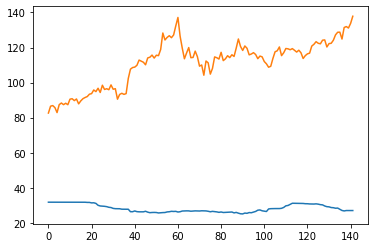









 36%|███▌      | 501/1400 [51:00<1:27:18,  5.83s/it]







 36%|███▌      | 502/1400 [51:05<1:25:34,  5.72s/it]







 36%|███▌      | 503/1400 [51:11<1:24:22,  5.64s/it]







 36%|███▌      | 504/1400 [51:16<1:23:31,  5.59s/it]







 36%|███▌      | 505/1400 [51:22<1:23:37,  5.61s/it]







 36%|███▌      | 506/1400 [51:27<1:23:15,  5.59s/it]







 36%|███▌      | 507/1400 [51:33<1:23:16,  5.60s/it]







 36%|███▋      | 508/1400 [51:39<1:23:16,  5.60s/it]







 36%|███▋      | 509/1400 [51:44<1:23:17,  5.61s/it]







 36%|███▋      | 510/1400 [51:50<1:23:35,  5.64s/it]







 36%|███▋      | 511/1400 [51:55<1:22:55,  5.60s/it]







 37%|███▋      | 512/1400 [52:01<1:23:23,  5.63s/it]







 37%|███▋      | 513/1400 [52:07<1:23:43,  5.66s/it]







 37%|███▋      | 514/1400 [52:13<1:24:27,  5.72s/it]







 37%|███▋      | 515/1400 [52:19<1:26:09,  5.84s/it]







 37%|███▋      | 516/1400 [52:25<1:27:03,  5.91s/it]







 37%|███▋      | 517/1400 [52:31

MAE
80.46409423639071



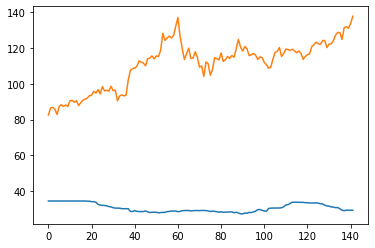









 39%|███▉      | 551/1400 [56:00<1:34:13,  6.66s/it]







 39%|███▉      | 552/1400 [56:06<1:32:56,  6.58s/it]







 40%|███▉      | 553/1400 [56:13<1:31:57,  6.51s/it]







 40%|███▉      | 554/1400 [56:19<1:31:06,  6.46s/it]







 40%|███▉      | 555/1400 [56:25<1:31:11,  6.48s/it]







 40%|███▉      | 556/1400 [56:32<1:30:06,  6.41s/it]







 40%|███▉      | 557/1400 [56:38<1:29:17,  6.36s/it]







 40%|███▉      | 558/1400 [56:44<1:28:41,  6.32s/it]







 40%|███▉      | 559/1400 [56:50<1:28:18,  6.30s/it]







 40%|████      | 560/1400 [56:57<1:29:31,  6.39s/it]







 40%|████      | 561/1400 [57:03<1:29:11,  6.38s/it]







 40%|████      | 562/1400 [57:10<1:28:56,  6.37s/it]







 40%|████      | 563/1400 [57:16<1:28:37,  6.35s/it]







 40%|████      | 564/1400 [57:22<1:28:04,  6.32s/it]







 40%|████      | 565/1400 [57:29<1:27:51,  6.31s/it]







 40%|████      | 566/1400 [57:35<1:26:57,  6.26s/it]







 40%|████      | 567/1400 [57:41

MAE
77.70492805614272



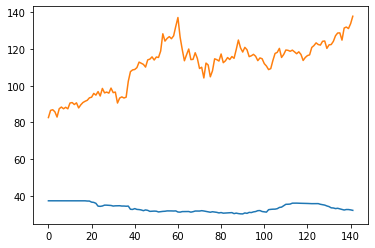









 43%|████▎     | 601/1400 [1:01:40<1:33:03,  6.99s/it]







 43%|████▎     | 602/1400 [1:01:46<1:29:54,  6.76s/it]







 43%|████▎     | 603/1400 [1:01:53<1:27:42,  6.60s/it]







 43%|████▎     | 604/1400 [1:01:59<1:26:00,  6.48s/it]







 43%|████▎     | 605/1400 [1:02:05<1:25:02,  6.42s/it]







 43%|████▎     | 606/1400 [1:02:11<1:23:38,  6.32s/it]







 43%|████▎     | 607/1400 [1:02:17<1:23:33,  6.32s/it]







 43%|████▎     | 608/1400 [1:02:24<1:23:21,  6.31s/it]







 44%|████▎     | 609/1400 [1:02:30<1:23:00,  6.30s/it]







 44%|████▎     | 610/1400 [1:02:37<1:23:45,  6.36s/it]







 44%|████▎     | 611/1400 [1:02:43<1:23:41,  6.36s/it]







 44%|████▎     | 612/1400 [1:02:49<1:24:16,  6.42s/it]







 44%|████▍     | 613/1400 [1:02:56<1:24:31,  6.44s/it]







 44%|████▍     | 614/1400 [1:03:02<1:24:42,  6.47s/it]







 44%|████▍     | 615/1400 [1:03:09<1:25:25,  6.53s/it]







 44%|████▍     | 616/1400 [1:03:16<1:25:11,  6.52s/it]









MAE
75.24736919590119



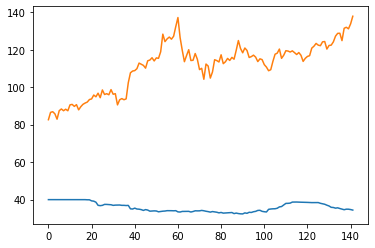









 46%|████▋     | 651/1400 [1:07:18<1:42:38,  8.22s/it]







 47%|████▋     | 652/1400 [1:07:25<1:39:50,  8.01s/it]







 47%|████▋     | 653/1400 [1:07:32<1:36:01,  7.71s/it]







 47%|████▋     | 654/1400 [1:07:39<1:32:50,  7.47s/it]







 47%|████▋     | 655/1400 [1:07:46<1:30:57,  7.33s/it]







 47%|████▋     | 656/1400 [1:07:53<1:28:20,  7.12s/it]







 47%|████▋     | 657/1400 [1:07:59<1:26:36,  6.99s/it]







 47%|████▋     | 658/1400 [1:08:06<1:25:17,  6.90s/it]







 47%|████▋     | 659/1400 [1:08:13<1:24:39,  6.86s/it]







 47%|████▋     | 660/1400 [1:08:20<1:27:00,  7.05s/it]







 47%|████▋     | 661/1400 [1:08:28<1:28:00,  7.15s/it]







 47%|████▋     | 662/1400 [1:08:35<1:28:42,  7.21s/it]







 47%|████▋     | 663/1400 [1:08:43<1:30:20,  7.36s/it]







 47%|████▋     | 664/1400 [1:08:50<1:31:06,  7.43s/it]







 48%|████▊     | 665/1400 [1:08:58<1:32:29,  7.55s/it]







 48%|████▊     | 666/1400 [1:09:06<1:31:55,  7.51s/it]









MAE
72.79908547655631



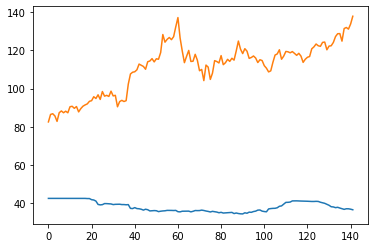









 50%|█████     | 701/1400 [1:12:52<1:21:27,  6.99s/it]







 50%|█████     | 702/1400 [1:12:58<1:20:25,  6.91s/it]







 50%|█████     | 703/1400 [1:13:05<1:18:43,  6.78s/it]







 50%|█████     | 704/1400 [1:13:11<1:17:47,  6.71s/it]







 50%|█████     | 705/1400 [1:13:18<1:17:31,  6.69s/it]







 50%|█████     | 706/1400 [1:13:24<1:16:45,  6.64s/it]







 50%|█████     | 707/1400 [1:13:31<1:16:35,  6.63s/it]







 51%|█████     | 708/1400 [1:13:38<1:16:19,  6.62s/it]







 51%|█████     | 709/1400 [1:13:44<1:16:51,  6.67s/it]







 51%|█████     | 710/1400 [1:13:51<1:17:51,  6.77s/it]







 51%|█████     | 711/1400 [1:13:58<1:17:24,  6.74s/it]







 51%|█████     | 712/1400 [1:14:05<1:16:22,  6.66s/it]







 51%|█████     | 713/1400 [1:14:11<1:15:59,  6.64s/it]







 51%|█████     | 714/1400 [1:14:18<1:15:16,  6.58s/it]







 51%|█████     | 715/1400 [1:14:24<1:15:04,  6.58s/it]







 51%|█████     | 716/1400 [1:14:31<1:14:26,  6.53s/it]









MAE
70.36512578425946



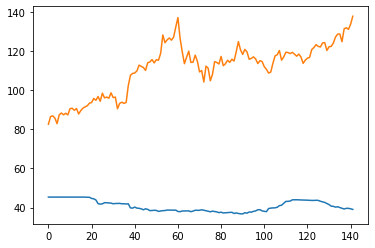









 54%|█████▎    | 751/1400 [1:18:22<1:22:28,  7.62s/it]







 54%|█████▎    | 752/1400 [1:18:30<1:22:02,  7.60s/it]







 54%|█████▍    | 753/1400 [1:18:37<1:21:14,  7.53s/it]







 54%|█████▍    | 754/1400 [1:18:45<1:20:17,  7.46s/it]







 54%|█████▍    | 755/1400 [1:18:52<1:19:41,  7.41s/it]







 54%|█████▍    | 756/1400 [1:18:59<1:17:53,  7.26s/it]







 54%|█████▍    | 757/1400 [1:19:06<1:16:48,  7.17s/it]







 54%|█████▍    | 758/1400 [1:19:13<1:16:19,  7.13s/it]







 54%|█████▍    | 759/1400 [1:19:20<1:16:45,  7.19s/it]







 54%|█████▍    | 760/1400 [1:19:27<1:17:00,  7.22s/it]







 54%|█████▍    | 761/1400 [1:19:34<1:16:26,  7.18s/it]







 54%|█████▍    | 762/1400 [1:19:42<1:16:08,  7.16s/it]







 55%|█████▍    | 763/1400 [1:19:49<1:16:00,  7.16s/it]







 55%|█████▍    | 764/1400 [1:19:56<1:15:50,  7.15s/it]







 55%|█████▍    | 765/1400 [1:20:03<1:15:30,  7.14s/it]







 55%|█████▍    | 766/1400 [1:20:10<1:14:21,  7.04s/it]









MAE
67.93664270776092



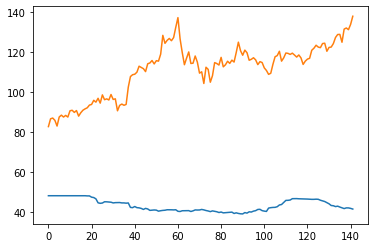









 57%|█████▋    | 801/1400 [1:24:14<1:14:03,  7.42s/it]







 57%|█████▋    | 802/1400 [1:24:20<1:12:06,  7.24s/it]







 57%|█████▋    | 803/1400 [1:24:28<1:11:31,  7.19s/it]







 57%|█████▋    | 804/1400 [1:24:35<1:11:46,  7.23s/it]







 57%|█████▊    | 805/1400 [1:24:42<1:12:22,  7.30s/it]







 58%|█████▊    | 806/1400 [1:24:50<1:13:08,  7.39s/it]







 58%|█████▊    | 807/1400 [1:24:58<1:14:57,  7.58s/it]







 58%|█████▊    | 808/1400 [1:25:06<1:15:30,  7.65s/it]







 58%|█████▊    | 809/1400 [1:25:13<1:15:36,  7.68s/it]







 58%|█████▊    | 810/1400 [1:25:22<1:16:32,  7.78s/it]







 58%|█████▊    | 811/1400 [1:25:29<1:16:30,  7.79s/it]







 58%|█████▊    | 812/1400 [1:25:37<1:16:12,  7.78s/it]







 58%|█████▊    | 813/1400 [1:25:45<1:16:31,  7.82s/it]







 58%|█████▊    | 814/1400 [1:25:53<1:16:12,  7.80s/it]







 58%|█████▊    | 815/1400 [1:26:01<1:16:45,  7.87s/it]







 58%|█████▊    | 816/1400 [1:26:09<1:16:07,  7.82s/it]









MAE
65.51723922862807



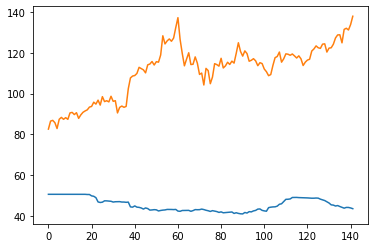









 61%|██████    | 851/1400 [1:30:34<1:13:59,  8.09s/it]







 61%|██████    | 852/1400 [1:30:42<1:12:56,  7.99s/it]







 61%|██████    | 853/1400 [1:30:49<1:11:46,  7.87s/it]







 61%|██████    | 854/1400 [1:30:57<1:10:46,  7.78s/it]







 61%|██████    | 855/1400 [1:31:04<1:10:01,  7.71s/it]







 61%|██████    | 856/1400 [1:31:12<1:09:52,  7.71s/it]







 61%|██████    | 857/1400 [1:31:20<1:09:19,  7.66s/it]







 61%|██████▏   | 858/1400 [1:31:27<1:09:40,  7.71s/it]







 61%|██████▏   | 859/1400 [1:31:35<1:09:22,  7.69s/it]







 61%|██████▏   | 860/1400 [1:31:43<1:09:14,  7.69s/it]







 62%|██████▏   | 861/1400 [1:31:50<1:08:26,  7.62s/it]







 62%|██████▏   | 862/1400 [1:31:58<1:07:45,  7.56s/it]







 62%|██████▏   | 863/1400 [1:32:05<1:07:00,  7.49s/it]







 62%|██████▏   | 864/1400 [1:32:12<1:06:44,  7.47s/it]







 62%|██████▏   | 865/1400 [1:32:20<1:07:13,  7.54s/it]







 62%|██████▏   | 866/1400 [1:32:28<1:07:05,  7.54s/it]









MAE
63.10602896702795



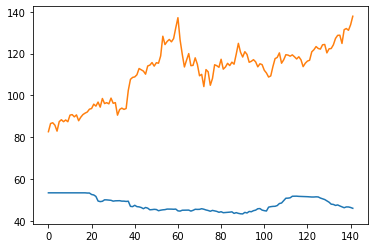









 64%|██████▍   | 901/1400 [1:36:58<1:08:20,  8.22s/it]







 64%|██████▍   | 902/1400 [1:37:05<1:06:49,  8.05s/it]







 64%|██████▍   | 903/1400 [1:37:13<1:05:33,  7.91s/it]







 65%|██████▍   | 904/1400 [1:37:20<1:04:08,  7.76s/it]







 65%|██████▍   | 905/1400 [1:37:28<1:03:53,  7.75s/it]







 65%|██████▍   | 906/1400 [1:37:36<1:03:09,  7.67s/it]







 65%|██████▍   | 907/1400 [1:37:43<1:03:30,  7.73s/it]







 65%|██████▍   | 908/1400 [1:37:51<1:03:56,  7.80s/it]







 65%|██████▍   | 909/1400 [1:37:59<1:03:48,  7.80s/it]







 65%|██████▌   | 910/1400 [1:38:07<1:03:27,  7.77s/it]







 65%|██████▌   | 911/1400 [1:38:14<1:02:25,  7.66s/it]







 65%|██████▌   | 912/1400 [1:38:22<1:02:10,  7.64s/it]







 65%|██████▌   | 913/1400 [1:38:29<1:01:38,  7.59s/it]







 65%|██████▌   | 914/1400 [1:38:37<1:01:36,  7.61s/it]







 65%|██████▌   | 915/1400 [1:38:45<1:01:46,  7.64s/it]







 65%|██████▌   | 916/1400 [1:38:52<1:00:59,  7.56s/it]









MAE
60.70496999094858



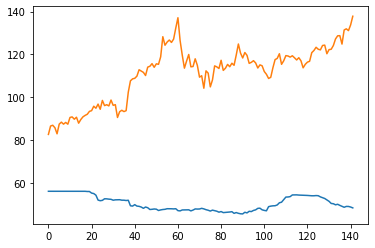









 68%|██████▊   | 951/1400 [1:43:29<1:03:48,  8.53s/it]







 68%|██████▊   | 952/1400 [1:43:37<1:02:41,  8.40s/it]







 68%|██████▊   | 953/1400 [1:43:45<1:02:08,  8.34s/it]







 68%|██████▊   | 954/1400 [1:43:53<1:01:08,  8.23s/it]







 68%|██████▊   | 955/1400 [1:44:02<1:02:04,  8.37s/it]







 68%|██████▊   | 956/1400 [1:44:10<1:01:40,  8.33s/it]







 68%|██████▊   | 957/1400 [1:44:19<1:02:26,  8.46s/it]







 68%|██████▊   | 958/1400 [1:44:27<1:01:19,  8.32s/it]







 68%|██████▊   | 959/1400 [1:44:34<59:34,  8.11s/it]  







 69%|██████▊   | 960/1400 [1:44:42<58:41,  8.00s/it]







 69%|██████▊   | 961/1400 [1:44:50<58:03,  7.93s/it]







 69%|██████▊   | 962/1400 [1:44:58<57:49,  7.92s/it]







 69%|██████▉   | 963/1400 [1:45:06<57:50,  7.94s/it]







 69%|██████▉   | 964/1400 [1:45:14<57:41,  7.94s/it]







 69%|██████▉   | 965/1400 [1:45:22<57:25,  7.92s/it]







 69%|██████▉   | 966/1400 [1:45:29<56:45,  7.85s/it]







 69%|██████▉  

MAE
57.66776232033382



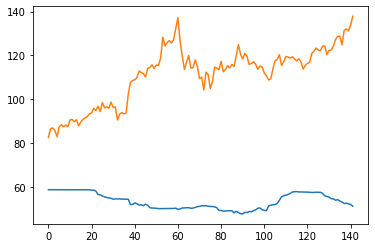









 72%|███████▏  | 1001/1400 [1:50:03<54:13,  8.15s/it]







 72%|███████▏  | 1002/1400 [1:50:11<53:10,  8.02s/it]







 72%|███████▏  | 1003/1400 [1:50:18<52:11,  7.89s/it]







 72%|███████▏  | 1004/1400 [1:50:26<51:24,  7.79s/it]







 72%|███████▏  | 1005/1400 [1:50:34<51:13,  7.78s/it]







 72%|███████▏  | 1006/1400 [1:50:41<50:22,  7.67s/it]







 72%|███████▏  | 1007/1400 [1:50:49<50:47,  7.75s/it]







 72%|███████▏  | 1008/1400 [1:50:57<50:13,  7.69s/it]







 72%|███████▏  | 1009/1400 [1:51:04<49:45,  7.63s/it]







 72%|███████▏  | 1010/1400 [1:51:12<49:26,  7.61s/it]







 72%|███████▏  | 1011/1400 [1:51:19<48:49,  7.53s/it]







 72%|███████▏  | 1012/1400 [1:51:27<48:41,  7.53s/it]







 72%|███████▏  | 1013/1400 [1:51:34<48:22,  7.50s/it]







 72%|███████▏  | 1014/1400 [1:51:42<48:29,  7.54s/it]







 72%|███████▎  | 1015/1400 [1:51:49<48:22,  7.54s/it]







 73%|███████▎  | 1016/1400 [1:51:57<47:55,  7.49s/it]







 73%|███████▎  |

MAE
55.31281056926957



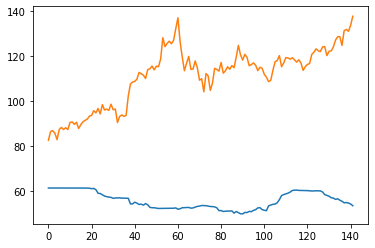









 75%|███████▌  | 1051/1400 [1:56:17<45:49,  7.88s/it]







 75%|███████▌  | 1052/1400 [1:56:25<45:01,  7.76s/it]







 75%|███████▌  | 1053/1400 [1:56:32<44:49,  7.75s/it]







 75%|███████▌  | 1054/1400 [1:56:40<44:41,  7.75s/it]







 75%|███████▌  | 1055/1400 [1:56:48<44:35,  7.76s/it]







 75%|███████▌  | 1056/1400 [1:56:56<44:55,  7.84s/it]







 76%|███████▌  | 1057/1400 [1:57:03<44:11,  7.73s/it]







 76%|███████▌  | 1058/1400 [1:57:11<43:38,  7.66s/it]







 76%|███████▌  | 1059/1400 [1:57:18<43:09,  7.59s/it]







 76%|███████▌  | 1060/1400 [1:57:26<42:53,  7.57s/it]







 76%|███████▌  | 1061/1400 [1:57:33<42:45,  7.57s/it]







 76%|███████▌  | 1062/1400 [1:57:41<42:25,  7.53s/it]







 76%|███████▌  | 1063/1400 [1:57:48<42:17,  7.53s/it]







 76%|███████▌  | 1064/1400 [1:57:56<41:53,  7.48s/it]







 76%|███████▌  | 1065/1400 [1:58:03<41:38,  7.46s/it]







 76%|███████▌  | 1066/1400 [1:58:10<41:00,  7.37s/it]







 76%|███████▌  |

MAE
52.88310609118034



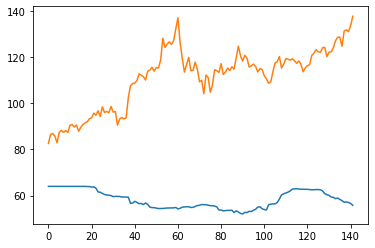









 79%|███████▊  | 1101/1400 [2:02:36<39:42,  7.97s/it]







 79%|███████▊  | 1102/1400 [2:02:43<38:57,  7.84s/it]







 79%|███████▉  | 1103/1400 [2:02:51<38:34,  7.79s/it]







 79%|███████▉  | 1104/1400 [2:02:58<38:15,  7.76s/it]







 79%|███████▉  | 1105/1400 [2:03:06<37:57,  7.72s/it]







 79%|███████▉  | 1106/1400 [2:03:14<37:26,  7.64s/it]







 79%|███████▉  | 1107/1400 [2:03:21<36:51,  7.55s/it]







 79%|███████▉  | 1108/1400 [2:03:28<36:33,  7.51s/it]







 79%|███████▉  | 1109/1400 [2:03:36<36:08,  7.45s/it]







 79%|███████▉  | 1110/1400 [2:03:43<35:34,  7.36s/it]







 79%|███████▉  | 1111/1400 [2:03:50<35:09,  7.30s/it]







 79%|███████▉  | 1112/1400 [2:03:57<35:12,  7.33s/it]







 80%|███████▉  | 1113/1400 [2:04:05<35:14,  7.37s/it]







 80%|███████▉  | 1114/1400 [2:04:12<35:11,  7.38s/it]







 80%|███████▉  | 1115/1400 [2:04:20<35:02,  7.38s/it]







 80%|███████▉  | 1116/1400 [2:04:27<34:37,  7.31s/it]







 80%|███████▉  |

MAE
50.42265351442218



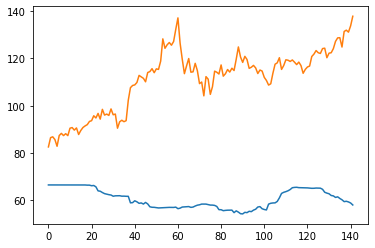









 82%|████████▏ | 1151/1400 [2:08:43<32:28,  7.82s/it]







 82%|████████▏ | 1152/1400 [2:08:50<31:53,  7.72s/it]







 82%|████████▏ | 1153/1400 [2:08:58<31:29,  7.65s/it]







 82%|████████▏ | 1154/1400 [2:09:05<30:57,  7.55s/it]







 82%|████████▎ | 1155/1400 [2:09:12<30:46,  7.54s/it]







 83%|████████▎ | 1156/1400 [2:09:20<30:07,  7.41s/it]







 83%|████████▎ | 1157/1400 [2:09:27<29:31,  7.29s/it]







 83%|████████▎ | 1158/1400 [2:09:34<29:05,  7.21s/it]







 83%|████████▎ | 1159/1400 [2:09:41<28:45,  7.16s/it]







 83%|████████▎ | 1160/1400 [2:09:48<28:34,  7.14s/it]







 83%|████████▎ | 1161/1400 [2:09:55<28:28,  7.15s/it]







 83%|████████▎ | 1162/1400 [2:10:02<28:35,  7.21s/it]







 83%|████████▎ | 1163/1400 [2:10:10<28:38,  7.25s/it]







 83%|████████▎ | 1164/1400 [2:10:17<28:37,  7.28s/it]







 83%|████████▎ | 1165/1400 [2:10:24<28:35,  7.30s/it]







 83%|████████▎ | 1166/1400 [2:10:31<28:17,  7.26s/it]







 83%|████████▎ |

MAE
48.02253032119175



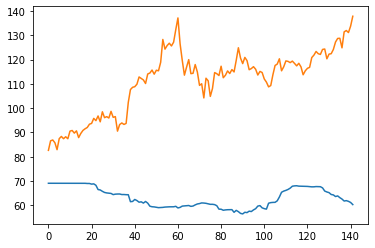









 86%|████████▌ | 1201/1400 [2:14:55<26:56,  8.12s/it]







 86%|████████▌ | 1202/1400 [2:15:03<26:45,  8.11s/it]







 86%|████████▌ | 1203/1400 [2:15:10<25:42,  7.83s/it]







 86%|████████▌ | 1204/1400 [2:15:17<24:57,  7.64s/it]







 86%|████████▌ | 1205/1400 [2:15:25<24:39,  7.59s/it]







 86%|████████▌ | 1206/1400 [2:15:32<24:11,  7.48s/it]







 86%|████████▌ | 1207/1400 [2:15:39<24:00,  7.46s/it]







 86%|████████▋ | 1208/1400 [2:15:47<24:05,  7.53s/it]







 86%|████████▋ | 1209/1400 [2:15:55<23:51,  7.49s/it]







 86%|████████▋ | 1210/1400 [2:16:02<23:58,  7.57s/it]







 86%|████████▋ | 1211/1400 [2:16:10<23:31,  7.47s/it]







 87%|████████▋ | 1212/1400 [2:16:17<23:11,  7.40s/it]







 87%|████████▋ | 1213/1400 [2:16:24<23:16,  7.47s/it]







 87%|████████▋ | 1214/1400 [2:16:32<23:04,  7.44s/it]







 87%|████████▋ | 1215/1400 [2:16:39<22:56,  7.44s/it]







 87%|████████▋ | 1216/1400 [2:16:47<22:40,  7.40s/it]







 87%|████████▋ |

MAE
45.830559764637094



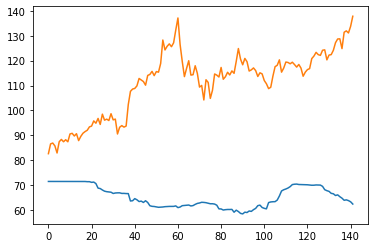









 89%|████████▉ | 1251/1400 [2:21:02<19:05,  7.69s/it]







 89%|████████▉ | 1252/1400 [2:21:10<18:41,  7.58s/it]







 90%|████████▉ | 1253/1400 [2:21:17<18:23,  7.50s/it]







 90%|████████▉ | 1254/1400 [2:21:24<18:10,  7.47s/it]







 90%|████████▉ | 1255/1400 [2:21:32<18:03,  7.47s/it]







 90%|████████▉ | 1256/1400 [2:21:39<17:32,  7.31s/it]







 90%|████████▉ | 1257/1400 [2:21:46<17:19,  7.27s/it]







 90%|████████▉ | 1258/1400 [2:21:53<17:03,  7.21s/it]







 90%|████████▉ | 1259/1400 [2:22:00<16:49,  7.16s/it]







 90%|█████████ | 1260/1400 [2:22:07<16:53,  7.24s/it]







 90%|█████████ | 1261/1400 [2:22:15<16:46,  7.24s/it]







 90%|█████████ | 1262/1400 [2:22:22<16:48,  7.31s/it]







 90%|█████████ | 1263/1400 [2:22:29<16:43,  7.32s/it]







 90%|█████████ | 1264/1400 [2:22:37<16:38,  7.34s/it]







 90%|█████████ | 1265/1400 [2:22:44<16:41,  7.42s/it]







 90%|█████████ | 1266/1400 [2:22:52<16:33,  7.41s/it]







 90%|█████████ |

MAE
43.882396799265514



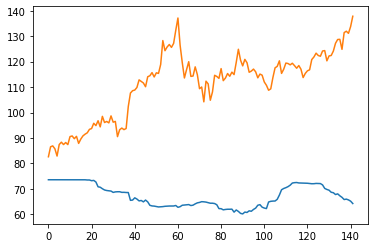









 93%|█████████▎| 1301/1400 [2:27:03<11:06,  6.73s/it]







 93%|█████████▎| 1302/1400 [2:27:10<10:49,  6.63s/it]







 93%|█████████▎| 1303/1400 [2:27:16<10:36,  6.57s/it]







 93%|█████████▎| 1304/1400 [2:27:23<10:30,  6.57s/it]







 93%|█████████▎| 1305/1400 [2:27:30<10:30,  6.64s/it]







 93%|█████████▎| 1306/1400 [2:27:36<10:21,  6.61s/it]







 93%|█████████▎| 1307/1400 [2:27:43<10:13,  6.60s/it]







 93%|█████████▎| 1308/1400 [2:27:49<10:00,  6.52s/it]







 94%|█████████▎| 1309/1400 [2:27:55<09:51,  6.50s/it]







 94%|█████████▎| 1310/1400 [2:28:02<09:48,  6.53s/it]







 94%|█████████▎| 1311/1400 [2:28:08<09:34,  6.46s/it]







 94%|█████████▎| 1312/1400 [2:28:15<09:23,  6.40s/it]







 94%|█████████▍| 1313/1400 [2:28:21<09:15,  6.39s/it]







 94%|█████████▍| 1314/1400 [2:28:27<09:11,  6.42s/it]







 94%|█████████▍| 1315/1400 [2:28:34<09:14,  6.52s/it]







 94%|█████████▍| 1316/1400 [2:28:41<09:03,  6.47s/it]







 94%|█████████▍|

MAE
43.69782691659056



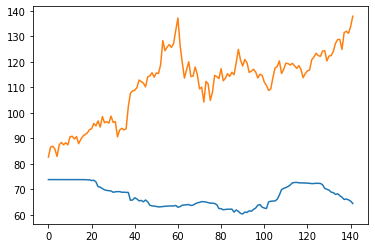









 96%|█████████▋| 1351/1400 [2:32:28<05:30,  6.74s/it]







 97%|█████████▋| 1352/1400 [2:32:35<05:19,  6.65s/it]







 97%|█████████▋| 1353/1400 [2:32:41<05:07,  6.55s/it]







 97%|█████████▋| 1354/1400 [2:32:47<04:59,  6.51s/it]







 97%|█████████▋| 1355/1400 [2:32:54<04:52,  6.50s/it]







 97%|█████████▋| 1356/1400 [2:33:00<04:42,  6.43s/it]







 97%|█████████▋| 1357/1400 [2:33:06<04:34,  6.38s/it]







 97%|█████████▋| 1358/1400 [2:33:13<04:28,  6.39s/it]







 97%|█████████▋| 1359/1400 [2:33:20<04:25,  6.48s/it]







 97%|█████████▋| 1360/1400 [2:33:26<04:22,  6.55s/it]







 97%|█████████▋| 1361/1400 [2:33:33<04:15,  6.56s/it]







 97%|█████████▋| 1362/1400 [2:33:39<04:09,  6.56s/it]







 97%|█████████▋| 1363/1400 [2:33:46<04:02,  6.55s/it]







 97%|█████████▋| 1364/1400 [2:33:52<03:54,  6.50s/it]







 98%|█████████▊| 1365/1400 [2:33:59<03:47,  6.50s/it]







 98%|█████████▊| 1366/1400 [2:34:05<03:40,  6.49s/it]







 98%|█████████▊|

In [96]:
returns = run_GAN()

In [84]:
returns_generated = returns[0]
returns_true = returns[1]

In [97]:
returns_true

[82.6193448073153,
 86.53962176342648,
 86.89036090154221,
 85.74860341280218,
 82.8954518172547,
 87.42516858368894,
 88.3430485283659,
 87.41273109857464,
 88.21619398683002,
 87.39531811795248,
 90.54447171235395,
 90.79322586211777,
 89.72361048585219,
 90.64645961499976,
 87.87043119407174,
 89.56937576265702,
 90.82307686434623,
 91.50216319477907,
 92.03696830865682,
 93.38268915856115,
 93.70855512262001,
 95.78063498255067,
 94.85777152573567,
 96.77810806919368,
 94.36524919037632,
 98.49447641617087,
 96.07913020890103,
 96.50199855254118,
 95.93485918465348,
 98.67606806361054,
 96.2084698042876,
 96.51194335975417,
 90.53203460511492,
 93.24090373280691,
 93.89512205160885,
 93.2807037369824,
 93.71601774645188,
 102.36998287255277,
 107.65837013253402,
 108.58620744901046,
 108.8299822945154,
 109.85233883989576,
 112.8414163311887,
 112.23835506302125,
 111.61037100961165,
 110.14260630066367,
 114.06247077652883,
 114.4611940397687,
 115.6897314394168,
 113.985224763231

In [ ]:
plt.plot(returns_generated, label = 'generated')
plt.plot(returns_true, label = 'true')
plt.legend()

In [605]:
#MAE
mean_absolute_error(returns_generated, returns_true)

18.175057003698715

In [606]:
#calculate generated and real returns
returns_percent_generated = []
for i in range (1, len(returns_generated)):
    returns_percent_generated.append( (returns_generated[i] - returns_generated[i-1])/returns_generated[i-1])
returns_percent_true= []
for i in range (1, len(returns_true)):
    returns_percent_true.append( (returns_true[i] - returns_true[i-1])/returns_true[i-1])

In [607]:
#trading strategy: buy if positive, nothing if negative
strategy_returns = []
for i in range (len(returns_percent_true)):
    if (returns_percent_generated[i] > 0):
        strategy_returns.append(returns_percent_true[i])
    else:
        strategy_returns.append(0)

1.9137289319462578
1.4325411274753184
0.00010692395144771673
0.20345949183619325
0.15071056330039215
-0.09023120905347894
0.30962343096234307


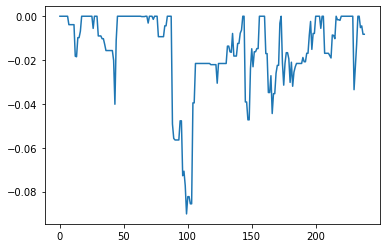

In [615]:
#eval strategy returns

#cumualtive reeturns real
cum_returns_real = 1
cum_ret_real = []
for i in range (len(returns_percent_true)):
    cum_returns_real  = cum_returns_real * (1 + returns_percent_true[i])
    cum_ret_real.append(cum_returns_real)
print (cum_returns_real)

#cumulative returns
cum_returns = 1
cum_ret = []
for i in range (len(strategy_returns)):
    cum_returns  = cum_returns * (1 + strategy_returns[i])
    cum_ret.append(cum_returns)
print (cum_returns)

#variance
variance = np.var(strategy_returns)
print (variance)

#sharpe real
std = np.std(returns_percent_true)
rfr = 0
sharpe = (np.average(returns_percent_true)- rfr)/std
print (sharpe)

#sharpe
std = np.std(strategy_returns)
rfr = 0
sharpe = (np.average(strategy_returns) - rfr)/std
print (sharpe)

#drawdown
previous_peaks = np.maximum.accumulate(cum_ret)
drawdown = (cum_ret-previous_peaks)/previous_peaks
max_drawdown = np.ndarray.min(drawdown)
print (max_drawdown)
plt.plot(drawdown)

#turnover
turnover = 0
for pred in strategy_returns:
    if (pred > 0):
        turnover += 1
turnover = turnover/len(strategy_returns)
print (turnover)

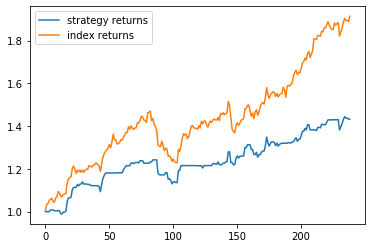

In [616]:
plt.plot(cum_ret, label = 'strategy returns')
plt.plot(cum_ret_real, label = 'index returns')
plt.legend()

In [612]:
sharpe = (np.average(strategy_returns) - 1 - rfr)/std
print (sharpe)



-96.55731129591832


In [618]:
np.var(strategy_returns)*100

0.010692395144771674

In [614]:
std

0.010340403833879833